In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import validation_curve
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, precision_recall_curve, plot_precision_recall_curve, average_precision_score

In [4]:
from sklearn.preprocessing import StandardScaler

# Read ETF Data

In [5]:
data = pd.read_csv('../Data/ETF/ETF_cleaned.csv')
data.head(3)

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,Sym,ExpirationDate,index,...,Spent,Sector,ChainLocation,Spent/contract,Spent/share,break_even,Contract period in hrs,Contract period in days,attention,Profit
0,0,256.619995,257.220001,255.630005,256.440002,240.434677,80811500,SPY,2017-11-15,42821,...,16000,ETF,OTM,160.0,1.6,258.6,6.674722,0,43.0,False
1,1,256.619995,257.220001,255.630005,256.440002,240.434677,80811500,SPY,2017-11-15,42830,...,36000,ETF,OTM,360.0,3.6,260.6,5.980000,0,43.0,False
2,2,256.619995,257.220001,255.630005,256.440002,240.434677,80811500,SPY,2017-11-15,42909,...,65000,ETF,ATM,650.0,6.5,264.0,31.097778,1,43.0,False


In [6]:
data.drop(['Unnamed: 0','Unnamed: 0.1', 'Spent', 'Spent/contract', 'Open', 'High', 'Low', 'Time', 'Close', 'Adj Close', 'OptionType', 'Sym', 'Expiration', 'ChainLocation', 'Sector', 'Contract period in days','index'], axis=1,inplace=True)
data['ExpirationDate'] = data['ExpirationDate'].astype('datetime64[ns]').map(dt.toordinal)
data['Date'] = data['Date'].astype('datetime64[ns]').map(dt.toordinal)
data['Profit'] = data["Profit"].astype(int)
data=data.reset_index(drop=True)

In [7]:
data.head(3)

,Volume,ExpirationDate,Strike,StockPrice,Date,Spent/share,break_even,Contract period in hrs,attention,Profit
0,80811500,736648,257.0,256.45,736648,1.6,258.6,6.674722,43.0,0
1,80811500,736648,257.0,256.95,736648,3.6,260.6,5.980000,43.0,0
2,80811500,736648,257.5,257.50,736647,6.5,264.0,31.097778,43.0,0


# Standardize data

In [8]:
X = data.loc[:, data.columns != 'Profit']
y = data.loc[:, data.columns == 'Profit']

In [9]:
scalar = StandardScaler()
x_std = scalar.fit_transform(X)

In [10]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(x_std, y,random_state = 123, test_size = 0.2)

# Split Data 80/20

**Data is very imbalanced, we do not have many positive responses**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data.loc[:, data.columns != 'Profit'], data.loc[:, data.columns == 'Profit'],random_state = 123, test_size = 0.2)

In [12]:
print("Profit is True: ",y_train[y_train == 1].count()[0])
print("Profit is False: ", y_train[y_train == 0].count()[0])

Profit is True:  324
Profit is False:  4216


In [13]:
print("Profit is True: ",y_test[y_test == 1].count()[0])
print("Profit is False: ", y_test[y_test == 0].count()[0])

Profit is True:  73
Profit is False:  1063


In [14]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
y_train_s = y_train_s.values.ravel()

# KNN

In [44]:
param_range_knn = np.arange(2,25)
train_scores_knn, test_scores_knn = validation_curve(KNeighborsClassifier(weights = "uniform"), X_train, y_train, param_name ="n_neighbors", param_range = param_range_knn, cv = 5)

In [45]:
train_scores_mean_knn = np.mean(train_scores_knn, axis = 1)
test_scores_mean_knn = np.mean(test_scores_knn, axis = 1)
train_scores_std_knn = np.std(train_scores_knn, axis = 1)
test_scores_std_knn = np.std(test_scores_knn, axis = 1)
knn_best = param_range_knn[np.argsort(test_scores_mean_knn)[-1]]
dist = KNeighborsClassifier(n_neighbors = knn_best, weights = "uniform").fit(X_train, y_train)

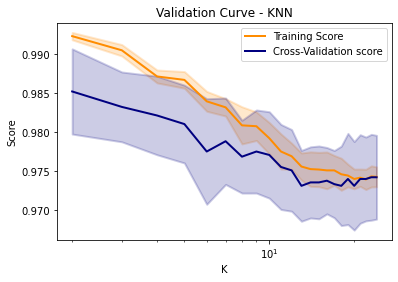

In [46]:
plt.title("Validation Curve - KNN")
plt.xlabel("K")
plt.ylabel("Score")

lw = 2
plt.semilogx(param_range_knn, train_scores_mean_knn, label="Training Score", color="darkorange", lw=lw)
plt.fill_between(param_range_knn, train_scores_mean_knn - train_scores_std_knn, train_scores_mean_knn + train_scores_std_knn, alpha=0.2,color="darkorange", lw=lw)
plt.semilogx(param_range_knn, test_scores_mean_knn, label="Cross-Validation score", color="navy", lw=lw)
plt.fill_between(param_range_knn, test_scores_mean_knn - test_scores_std_knn, test_scores_mean_knn + test_scores_std_knn, alpha=0.2, color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [47]:
print("The best parameter K : ", knn_best)
acc_train = dist.score(X_train, y_train)
print('Training accuracy:', acc_train)
print('Test accuracy is:', dist.score(X_test, y_test))

The best parameter K :  2
Training accuracy: 0.9931718061674009
Test accuracy is: 0.9859154929577465


Confusion Matrix with KNN:


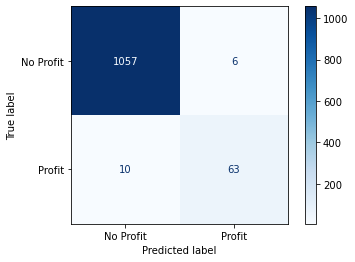

In [48]:
CM_knn = plot_confusion_matrix(dist, X_test, y_test, display_labels= ["No Profit", "Profit"], cmap=plt.cm.Blues)
print("Confusion Matrix with KNN:")
plt.show()

**Because of imbalance in the data, the model is bias and predicted over half of the Profit call options incorrectly. We will try SMOTE and NearMiss to see if it can help fix the bias in our KNN model.**

# 1. Synthetic Minority Oversampling Technique (SMOTE)

https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-14-106

In [47]:
!pip install imblearn

distutils: c:\users\saura\python\Include\UNKNOWN
sysconfig: c:\users\saura\python\Include
user = False
home = None
root = None
prefix = None
distutils: c:\users\saura\python\Include\UNKNOWN
sysconfig: c:\users\saura\python\Include
user = False
home = None
root = None
prefix = None
You should consider upgrading via the 'c:\users\saura\python\python.exe -m pip install --upgrade pip' command.


In [15]:
!pip install delayed

distutils: c:\users\saura\python\Include\UNKNOWN
sysconfig: c:\users\saura\python\Include
user = False
home = None
root = None
prefix = None
distutils: c:\users\saura\python\Include\UNKNOWN
sysconfig: c:\users\saura\python\Include
user = False
home = None
root = None
prefix = None
You should consider upgrading via the 'c:\users\saura\python\python.exe -m pip install --upgrade pip' command.


In [16]:
import imblearn
print(imblearn.__version__)
from imblearn.over_sampling import SMOTE
from collections import Counter

0.8.0


In [17]:
Counter(y_train)

Counter({0: 4216, 1: 324})

In [18]:
oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)
counter_smote = Counter(y_train_smote)
print(counter_smote)

Counter({0: 4216, 1: 4216})


In [19]:
X_train_smote_s, y_train_smote_s = oversample.fit_resample(X_train_s, y_train_s)
counter_smote_s = Counter(y_train_smote_s)

# 1.1 KNN

In [54]:
param_range_knn_1 = np.arange(2,25)
train_scores_knn_1, test_scores_knn_1 = validation_curve(KNeighborsClassifier(weights = "uniform"), X_train_smote, y_train_smote, param_name ="n_neighbors", param_range = param_range_knn_1, cv = 5)
train_scores_mean_knn_1 = np.mean(train_scores_knn_1, axis = 1)
test_scores_mean_knn_1 = np.mean(test_scores_knn_1, axis = 1)
train_scores_std_knn_1 = np.std(train_scores_knn_1, axis = 1)
test_scores_std_knn_1 = np.std(test_scores_knn_1, axis = 1)
knn_best_1 = param_range_knn_1[np.argsort(test_scores_mean_knn_1)[-1]]
dist_1 = KNeighborsClassifier(n_neighbors = knn_best_1, weights = "uniform").fit(X_train_smote, y_train_smote)

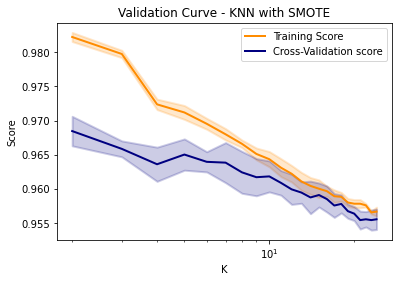

In [55]:
plt.title("Validation Curve - KNN with SMOTE")
plt.xlabel("K")
plt.ylabel("Score")

lw = 2
plt.semilogx(param_range_knn_1, train_scores_mean_knn_1, label="Training Score", color="darkorange", lw=lw)
plt.fill_between(param_range_knn_1, train_scores_mean_knn_1 - train_scores_std_knn_1, train_scores_mean_knn_1 + train_scores_std_knn_1, alpha=0.2,color="darkorange", lw=lw)
plt.semilogx(param_range_knn_1, test_scores_mean_knn_1, label="Cross-Validation score", color="navy", lw=lw)
plt.fill_between(param_range_knn_1, test_scores_mean_knn_1 - test_scores_std_knn_1, test_scores_mean_knn_1 + test_scores_std_knn_1, alpha=0.2, color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [56]:
print("The best parameter K : ", knn_best_1)
acc_train_1 = dist_1.score(X_train_smote, y_train_smote)
print('Training accuracy:', acc_train_1)
print('Test accuracy is:', dist_1.score(X_test, y_test))

The best parameter K :  2
Training accuracy: 0.9839895635673624
Test accuracy is: 0.983274647887324


Confusion Matrix with KNN:


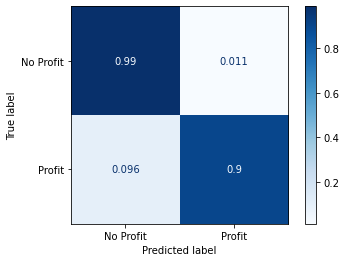

In [57]:
CM_knn = plot_confusion_matrix(dist_1, X_test, y_test, display_labels= ["No Profit", "Profit"], cmap=plt.cm.Blues,normalize='true')
print("Confusion Matrix with KNN:")
plt.show()

In [58]:
y_pred = dist_1.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1063
           1       0.85      0.90      0.87        73

    accuracy                           0.98      1136
   macro avg       0.92      0.95      0.93      1136
weighted avg       0.98      0.98      0.98      1136



# 1.2 SVM RBF Kernel

In [59]:
def svm_val_curv(param_range, model, xt,yt):
  # select from the range
  print("param range:", param_range)
  #test for values of C and set cross validation to 5
  train_scores, test_scores = validation_curve(
    model, xt,yt, param_name="C", param_range=param_range,
      scoring="accuracy", n_jobs=1, cv = 5)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  print("test scores mean:", test_scores_mean)

  # Plot CV error as a function of C
  plt.title("Validation Curve with SVM")
  plt.xlabel("C parameter")
  plt.ylabel("Score")
  lw = 2
  plt.semilogx(param_range, train_scores_mean, label="Training score",
              color="darkorange", lw=lw)
  plt.fill_between(param_range, train_scores_mean - train_scores_std,
                  train_scores_mean + train_scores_std, alpha=0.2,
                  color="darkorange", lw=lw)
  plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
              color="navy", lw=lw)
  plt.fill_between(param_range, test_scores_mean - test_scores_std,
                  test_scores_mean + test_scores_std, alpha=0.2,
                  color="navy", lw=lw)
  plt.legend(loc="best")
  plt.show()
  return test_scores_mean

In [60]:
svc_model_rbf_smote = SVC(kernel='rbf', probability=True)

In [61]:
param_range = np.logspace(-5,5, 6)

param range: [1.e-05 1.e-03 1.e-01 1.e+01 1.e+03 1.e+05]
test scores mean: [0.67817326 0.80597838 0.90085449 0.91461135 0.91496715 0.91472997]


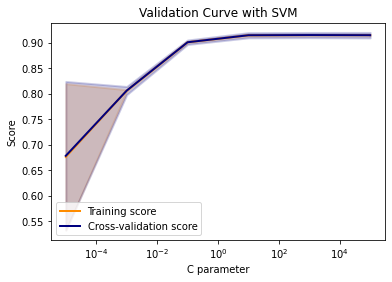

In [62]:
test_scores_mean = svm_val_curv(param_range, svc_model_rbf_smote,X_train_smote, y_train_smote)

In [63]:
C_best = param_range[np.argsort(test_scores_mean)[-1]]
print("The best hyperparameter: ", C_best)

dist = SVC(kernel='rbf',C = C_best, probability = True)
dist.fit(X_train_smote, y_train_smote)
acc_train = dist.score(X_train_smote, y_train_smote)
acc_test = dist.score(X_test, y_test)

print('Training accuracy:', acc_train)
print('Test accuracy:', acc_test)

The best hyperparameter:  1000.0
Training accuracy: 0.9149667931688804
Test accuracy: 0.9471830985915493


Confusion Matrix with RBF SVM SMOTE:


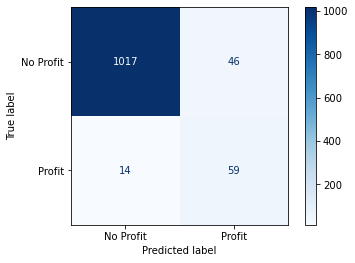

In [64]:
CM_svm = plot_confusion_matrix(dist, X_test, y_test, display_labels= ["No Profit", "Profit"], cmap=plt.cm.Blues)
print("Confusion Matrix with RBF SVM SMOTE:")
plt.show()

In [65]:
y_pred = dist.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1063
           1       0.56      0.81      0.66        73

    accuracy                           0.95      1136
   macro avg       0.77      0.88      0.82      1136
weighted avg       0.96      0.95      0.95      1136



# 1.3 Neural Networks

In [66]:
activation_funcs = ['logistic', 'relu'] 
param_grid = dict(hidden_layer_sizes = [(20,10),(50,25),(40,20)], activation = activation_funcs, batch_size = [32,64], alpha = [0.0001,0.001,0.01])
grid = GridSearchCV(MLPClassifier(), param_grid = param_grid)

In [67]:
grid.fit(X_train_smote, y_train_smote)

GridSearchCV(estimator=MLPClassifier(),
             param_grid={'activation': ['logistic', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01], 'batch_size': [32, 64],
                         'hidden_layer_sizes': [(20, 10), (50, 25), (40, 20)]})

In [68]:
grid.best_params_

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 32,
 'hidden_layer_sizes': (40, 20)}

In [20]:
dist_nn = MLPClassifier(hidden_layer_sizes = (40,20), activation = 'relu', alpha = 0.0001, batch_size = 32, random_state = 123).fit(X_train_smote, y_train_smote)

In [21]:
acc_train = dist_nn.score(X_train_smote, y_train_smote)
print('Training accuracy:', acc_train)
print('Test accuracy is:', dist_nn.score(X_test, y_test))

Training accuracy: 0.9173387096774194
Test accuracy is: 0.9454225352112676


In [22]:
y_pred = dist_nn.predict(X_test)
np.unique(y_pred)

array([0, 1])

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1063
           1       0.55      0.81      0.66        73

    accuracy                           0.95      1136
   macro avg       0.77      0.88      0.81      1136
weighted avg       0.96      0.95      0.95      1136



Confusion Matrix with Neural Network:


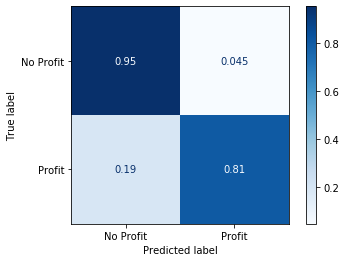

In [26]:
CM_nn = plot_confusion_matrix(dist_nn, X_test, y_test, display_labels= ["No Profit", "Profit"], cmap=plt.cm.Blues,normalize = 'true')
print("Confusion Matrix with Neural Network:")
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve:')

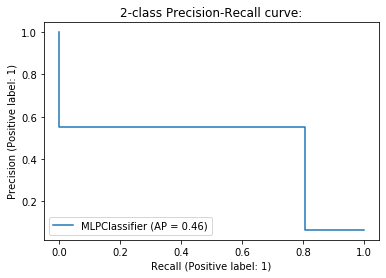

In [27]:
disp = plot_precision_recall_curve(dist_nn, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve:')

In [28]:
average_precision_score(y_test, y_pred)

0.45797750914654484

# 1.4 Logistic Regression

In [76]:
from sklearn.linear_model import LogisticRegression

In [77]:
c_range = np.logspace(-4, 6, 6)

In [78]:
train_scores_l2, valid_scores_l2 = validation_curve(LogisticRegression(solver='lbfgs', max_iter = 1000), X_train_smote_s, y_train_smote_s, param_name = "C", param_range = c_range, cv=5)

In [79]:
train_scores_mean_l2 = np.mean(train_scores_l2, axis = 1)
test_scores_mean_l2 = np.mean(valid_scores_l2, axis = 1)
train_scores_std_l2 = np.std(train_scores_l2, axis = 1)
test_scores_std_l2 = np.std(valid_scores_l2, axis = 1)

In [80]:
c_best = c_range[np.argsort(test_scores_mean_l2)[-1]]
LR_l2 = LogisticRegression(solver='lbfgs',C = c_best).fit(X_train_smote, y_train_smote)

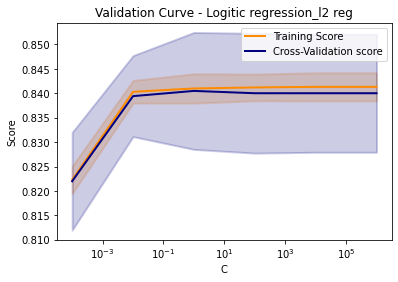

In [81]:
plt.title("Validation Curve - Logitic regression_l2 reg")
plt.xlabel("C")
plt.ylabel("Score")

lw = 2
plt.semilogx(c_range, train_scores_mean_l2, label="Training Score", color="darkorange", lw=lw)
plt.fill_between(c_range, train_scores_mean_l2 - train_scores_std_l2, train_scores_mean_l2 + train_scores_std_l2, alpha=0.2,color="darkorange", lw=lw)
plt.semilogx(c_range, test_scores_mean_l2, label="Cross-Validation score", color="navy", lw=lw)
plt.fill_between(c_range, test_scores_mean_l2 - test_scores_std_l2, test_scores_mean_l2 + test_scores_std_l2, alpha=0.2, color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [82]:
test_scores_mean_l2

array([0.8219865 , 0.83942148, 0.84048923, 0.84001488, 0.84001488,
       0.84001488])

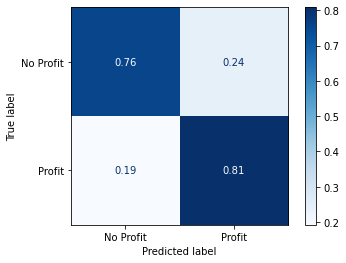

In [83]:
plot_confusion_matrix(LR_l2, X_test, y_test, display_labels= ["No Profit", "Profit"], cmap=plt.cm.Blues, normalize = 'true')

In [84]:
y_pred = LR_l2.predict(X_test_s)

In [85]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.60      0.74      1063
           1       0.12      0.77      0.20        73

    accuracy                           0.61      1136
   macro avg       0.55      0.68      0.47      1136
weighted avg       0.92      0.61      0.71      1136



# 1.5 Decision Trees

In [86]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [39]:
max_depth = np.arange(10,50,2)

In [40]:
train_scores_dc, valid_scores_dc= validation_curve(DecisionTreeClassifier(), X_train_smote, y_train_smote, param_name = "max_depth", param_range = max_depth, cv=5)

In [41]:
train_scores_mean_dc = np.mean(train_scores_dc, axis = 1)
test_scores_mean_dc = np.mean(valid_scores_dc, axis = 1)
train_scores_std_dc = np.std(train_scores_dc, axis = 1)
test_scores_std_dc = np.std(valid_scores_dc, axis = 1)

In [42]:
test_scores_mean_dc

array([0.98766634, 0.98920824, 0.98908976, 0.99027558, 0.99027551,
       0.98968267, 0.9893268 , 0.98991992, 0.98968281, 0.99039413,
       0.98932694, 0.98920838, 0.99051283, 0.9895639 , 0.98873382,
       0.98908969, 0.9890899 , 0.9896826 , 0.98932694, 0.98980136])

In [43]:
depth_best = max_depth[np.argsort(test_scores_mean_dc)[-1]]
DC_m1 = DecisionTreeClassifier(max_depth = depth_best, random_state=0).fit(X_train_smote, y_train_smote)

In [44]:
print("The best Depth of the tree is: ", depth_best)

The best Depth of the tree is:  34


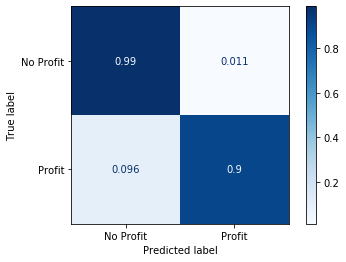

In [45]:
plot_confusion_matrix(DC_m1, X_test, y_test, display_labels= ["No Profit", "Profit"], cmap=plt.cm.Blues, normalize='true')

In [46]:
y_pred = DC_m1.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1063
           1       0.85      0.90      0.87        73

    accuracy                           0.98      1136
   macro avg       0.92      0.95      0.93      1136
weighted avg       0.98      0.98      0.98      1136



# 1.6 Random forest grid CV

In [94]:
from sklearn.ensemble import RandomForestClassifier as RFC
rfc=RFC(random_state=0)

In [95]:
param_grid = { 
    'n_estimators': np.arange(10,200,20),
    'max_depth' : np.arange(10,55,5),
}

In [96]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': array([10, 15, 20, 25, 30, 35, 40, 45, 50]),
                         'n_estimators': array([ 10,  30,  50,  70,  90, 110, 130, 150, 170, 190])})

In [97]:
CV_rfc.best_params_

{'max_depth': 15, 'n_estimators': 70}

In [98]:
rfc1=RFC(random_state=0, n_estimators= 50, max_depth=25, criterion='gini')

In [99]:
rfc1.fit(X_train_smote, y_train_smote)

RandomForestClassifier(max_depth=25, n_estimators=50, random_state=0)

In [100]:
y_pred_rfc1 = rfc1.predict(X_test)

In [101]:
print(classification_report(y_test, y_pred_rfc1))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1063
           1       0.97      0.90      0.94        73

    accuracy                           0.99      1136
   macro avg       0.98      0.95      0.97      1136
weighted avg       0.99      0.99      0.99      1136



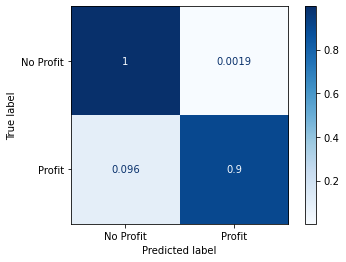

In [102]:
plot_confusion_matrix(rfc1, X_test, y_test, display_labels= ["No Profit", "Profit"], cmap=plt.cm.Blues, normalize='true')